# Human Activity Recognition for Healthy Lifestyle Monitoring

Group 40: Alvaro Menéndez Ros, Juan José Leguineche Gállego, Pablo Herrero Ortiz

## Description

This project implements a **Human Activity Recognition system** using smartphone sensor data to classify five core daily activities: sitting down, standing up, walking, running, and climbing stairs. The solution follows a complete pipeline, including:

1. **Data Acquisition**: Collecting raw accelerometer, gravitational and gyroscope signals from smartphones during different activities.  
2. **Preprocessing**: Cleaning and segmenting noisy time-series data into structured windows.  
3. **Feature Extraction**: Deriving meaningful statistical and frequency-based features that capture movement patterns.  
4. **Model Development**: Training supervised machine learning models to distinguish between activities.  
5. **Evaluation**: Assessing model performance using accuracy, precision, recall, and confusion matrices to ensure robustness.  

By simulating real-world challenges in digital health, the system demonstrates how wearable sensor data can be transformed into actionable insights for **health monitoring and activity tracking applications**.  


In [64]:
# Python version: 3.13.5
# Required packages: numpy, pandas, matplotlib, seaborn, scikit-learn, scipy, sklearn-extra

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# Optional fuzzy C-means (pip install scikit-fuzzy)
import skfuzzy as fuzz

## Data Acquisition



In [65]:
data_path = "../data/merged_data.csv"
df = pd.read_csv(data_path)

df.head()

,time,seconds_elapsed,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,grav_x,grav_y,grav_z,label,session_id
0,1757685564789874000,0.000000,0.001375,0.007425,0.006875,-0.003911,-0.329490,0.012606,-1.157310,-9.492284,2.174283,sitting_down,3
1,1757685564799427000,0.009553,0.001375,0.000137,0.014300,0.019475,-0.328793,0.087064,-1.157006,-9.492508,2.173465,sitting_down,3
2,1757685564808980200,0.019106,0.000137,-0.005912,0.020350,0.011755,-0.314396,0.134700,-1.156053,-9.492723,2.173028,sitting_down,3
3,1757685564818533000,0.028659,-0.002337,-0.003575,0.020350,-0.018417,-0.341251,0.166343,-1.154445,-9.492887,2.173158,sitting_down,3
4,1757685564828086300,0.038212,-0.003575,0.000137,0.021588,-0.019810,-0.315582,0.168639,-1.152299,-9.492996,2.173811,sitting_down,3


 ## Preprocessing


In [66]:
# Encode labels
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

# Features and labels
X = df.drop(columns=["time","label","session_id","label_encoded"])
y = df["label_encoded"]

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Classes:", le.classes_)

Classes: ['climbing_stairs' 'running' 'sitting_down' 'standing_up' 'still'
 'walking']


## Feature extraction

In [67]:
# Define window size (e.g. 2s window with 100Hz sampling = 200 samples)
window_size = 200
step_size = 100     # 50% overlap
min_fraction = 0.6  # at least 60% of samples same label    

features, labels, session_ids = [], [], []

for session_id, df_sess in df.groupby("session_id"):   # loop per session
    X_sess = df_sess.drop(columns=["time","label","session_id","label_encoded"])
    y_sess = df_sess["label_encoded"].values
    
    for start in range(0, len(X_sess) - window_size + 1, step_size):
        end = start + window_size
        window = X_sess.iloc[start:end]
        window_labels = y_sess[start:end]
        
        # check label purity and skip label mixed windows
        majority_label = pd.Series(window_labels).mode()[0]
        frac = np.mean(window_labels == majority_label)
        if frac < min_fraction:
            continue
        
        feats = []
        for col in window.columns:
            vals = window[col].values
            feats.extend([
                vals.mean(),
                vals.std(),
                vals.min(),
                vals.max(),
                np.median(vals),
                pd.Series(vals).skew()
            ])
        features.append(feats)
        labels.append(majority_label)
        session_ids.append(session_id)

X_feat = pd.DataFrame(features)
y_feat = np.array(labels)

print("Feature matrix shape:", X_feat.shape)

Feature matrix shape: (348, 60)


## Scaling, CV and Splitting

In [68]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feat)

In [69]:
gkf = GroupKFold(n_splits=5)

models = { # Esta definicion de models corresponde a supervised, pero hay que revisarlo
    "LogReg": LogisticRegression(max_iter=5000, solver="saga"),
    "DecisionTree": DecisionTreeClassifier(),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

print("Cross-validation results (F1-weighted, GroupKFold):")
for name, model in models.items():
    scores = cross_val_score(
        model, 
        X_scaled, 
        y_feat, 
        groups=session_ids,   # ensures no leakage across sessions
        cv=gkf, 
        scoring="f1_weighted"
    )
    print(f"{name:12s}: {scores.mean():.3f} ± {scores.std():.3f}")

Cross-validation results (F1-weighted, GroupKFold):
LogReg      : 0.000 ± 0.000
DecisionTree: 0.000 ± 0.000
NaiveBayes  : 0.000 ± 0.000
KNN         : 0.000 ± 0.000


In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_feat, test_size=0.2, random_state=42, stratify=y_feat
)

## Supervised Learning

In [71]:
models = {
    "LogReg": LogisticRegression(max_iter=5000, solver="saga"),
    "DecisionTree": DecisionTreeClassifier(),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "F1": f1_score(y_test, preds, average="weighted"),
        "Kappa": cohen_kappa_score(y_test, preds),
        "Confusion": confusion_matrix(y_test, preds)
    }

results

{'LogReg': {'Accuracy': 0.9714285714285714,
  'F1': 0.9714285714285714,
  'Kappa': 0.965703086722195,
  'Confusion': array([[12,  0,  0,  0,  0,  0],
         [ 0, 12,  0,  0,  0,  0],
         [ 0,  0, 10,  1,  0,  0],
         [ 0,  0,  1, 10,  0,  0],
         [ 0,  0,  0,  0, 12,  0],
         [ 0,  0,  0,  0,  0, 12]])},
 'DecisionTree': {'Accuracy': 0.9428571428571428,
  'F1': 0.942020268061458,
  'Kappa': 0.93140617344439,
  'Confusion': array([[11,  1,  0,  0,  0,  0],
         [ 0, 12,  0,  0,  0,  0],
         [ 0,  0, 11,  0,  0,  0],
         [ 0,  0,  3,  8,  0,  0],
         [ 0,  0,  0,  0, 12,  0],
         [ 0,  0,  0,  0,  0, 12]])},
 'NaiveBayes': {'Accuracy': 0.9714285714285714,
  'F1': 0.9711904761904762,
  'Kappa': 0.965703086722195,
  'Confusion': array([[12,  0,  0,  0,  0,  0],
         [ 0, 12,  0,  0,  0,  0],
         [ 0,  0,  9,  2,  0,  0],
         [ 0,  0,  0, 11,  0,  0],
         [ 0,  0,  0,  0, 12,  0],
         [ 0,  0,  0,  0,  0, 12]])},
 'KNN': 

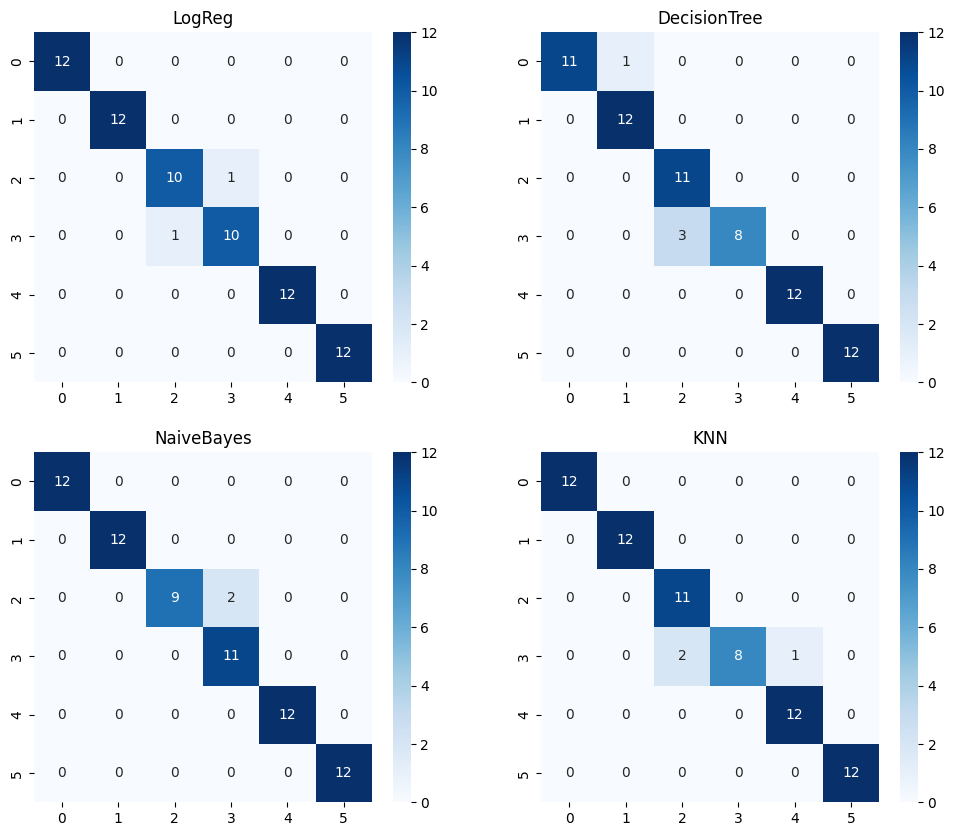

In [72]:
# Plot confusion matrices
fig, axes = plt.subplots(2,2, figsize=(12,10))
for ax,(name,res) in zip(axes.flatten(), results.items()):
    sns.heatmap(res["Confusion"], annot=True, fmt="d", ax=ax, cmap="Blues")
    ax.set_title(name)
plt.show()

### Results explanation

- Logistic regression benefits from scaling and well-engineered features.

- Trees handle mixed features well.

- Naive Bayes sometimes suffers when features are correlated, but still does okay.

- KNN struggles when classes overlap in feature space (walking vs. standing_up, both being moderate-intensity movements). When added scaling, results are improved significantly

## Unsupervised Learning

In [73]:
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_feat)

# K-Means
kmeans = KMeans(n_clusters=len(le.classes_), random_state=42).fit(X_feat)
kmeans_labels = kmeans.labels_

# Gaussian Mixture
gmm = GaussianMixture(n_components=len(le.classes_), random_state=42).fit(X_feat)
gmm_labels = gmm.predict(X_feat)

# Fuzzy C-Means
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X_feat.T, c=len(le.classes_), m=2, error=0.005, maxiter=1000, init=None)
fcm_labels = np.argmax(u, axis=0)

unsup_labels = {"KMeans": kmeans_labels, "GMM": gmm_labels, "FuzzyCMeans": fcm_labels}

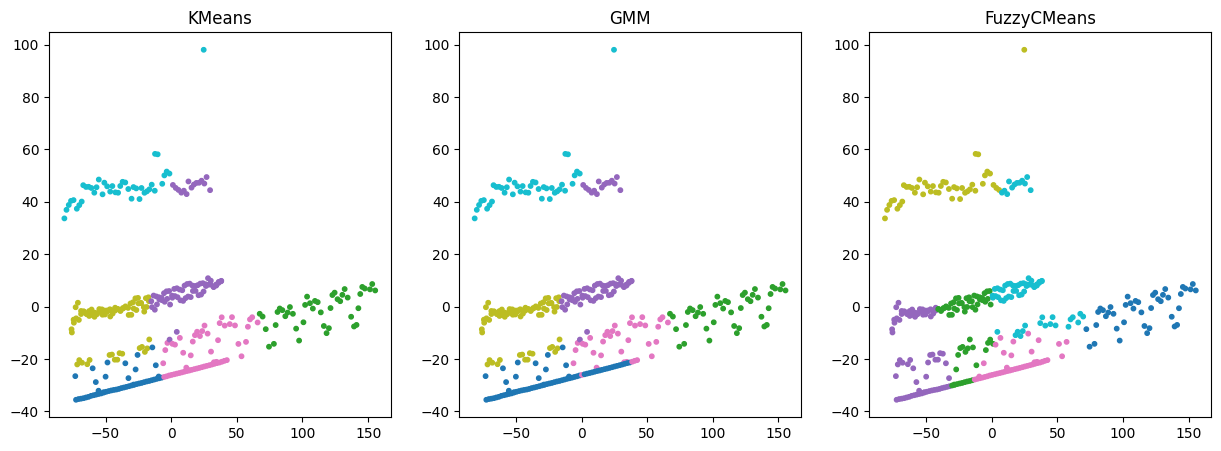

In [74]:
# Plot clustering results in PCA space
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax,(name, labels_) in zip(axes, unsup_labels.items()):
    scatter = ax.scatter(X_pca[:,0], X_pca[:,1], c=labels_, cmap="tab10", s=10)
    ax.set_title(name)
plt.show()

## Model Comparison

In [75]:
# Supervised comparison table
supervised_df = pd.DataFrame(results).T[["Accuracy","F1","Kappa"]]
print(supervised_df)

# Example unsupervised evaluation: Adjusted Rand Index vs true labels
from sklearn.metrics import adjusted_rand_score

unsup_scores = {name: adjusted_rand_score(y_feat, labels_) for name, labels_ in unsup_labels.items()}
unsup_scores

              Accuracy        F1     Kappa
LogReg        0.971429  0.971429  0.965703
DecisionTree  0.942857   0.94202  0.931406
NaiveBayes    0.971429   0.97119  0.965703
KNN           0.957143  0.955236  0.948542


{'KMeans': 0.32362320034132713,
 'GMM': 0.394805686974913,
 'FuzzyCMeans': 0.222794647694101}

## Evaluation

In [76]:
# Identify best model
best_model = supervised_df["Accuracy"].idxmax()
print("Best performing supervised model:", best_model)

# Save summary
#supervised_df.to_csv("../data/supervised_results.csv")
#pd.DataFrame.from_dict(unsup_scores, orient="index", columns=["ARI"]).to_csv("../data/unsupervised_results.csv")

Best performing supervised model: LogReg
